In [3]:
import os
os.chdir(r'/content/drive/MyDrive/Work/PI_deepOnet_General/Posting/Pendulum')
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.io
import math
import scipy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
import os
import csv
#from models import Green_transformer

class SimpleCSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath

        # If the file doesn't exist, create one with headers.
        if not os.path.exists(filepath):
            with open(filepath, 'w', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(['epoch', 'metric', 'value'])

    def log(self, epoch, metric, value):
        with open(self.filepath, 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow([epoch, metric, value])

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Data = scipy.io.loadmat('Data.mat')

Input = torch.tensor(Data['F'], dtype = torch.float32).to(device)
Output = torch.tensor(Data['U'], dtype = torch.float32).to(device)

COOR = torch.tensor(Data['coors']).permute(1,0).cuda()
coor  = COOR.repeat(len(Input),1,1).float()

Input = Input[:,:,None]
Output = Output[:,:,None]

Length = len(Input)

# torch.manual_seed(0)
# np.random.seed(0)


In [4]:
batch_size = 16

x_data = Input
cx_data = coor
y_data = Output

x_train = x_data[0:int(0.8*Length),:,:]
cx_train = cx_data[0:int(0.8*Length),:,:]
y_train = y_data[0:int(0.8*Length),:,:]

x_test = x_data[int(0.8*Length):Length,:,:]
cx_test = cx_data[int(0.8*Length):Length,:,:]
y_test = y_data[int(0.8*Length):Length,:,:]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, cx_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, cx_test, y_test), batch_size=batch_size, shuffle=False)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [8]:
class MLP1(nn.Module):
    def __init__(self,width_trunk, width_branch, length):
        super().__init__()
        layers = np.array([length,width_branch,width_branch,width_branch,width_branch,width_trunk])
        self.linears = torch.nn.Sequential(nn.Linear(layers[0],layers[1]), torch.nn.ReLU(),
                                           nn.Linear(layers[1],layers[2]), torch.nn.ReLU(),
                                           nn.Linear(layers[2],layers[3]), torch.nn.ReLU(),
                                           nn.Linear(layers[3],layers[4]), torch.nn.ReLU(),
                                           nn.Linear(layers[4],layers[5]))

    def forward(self,x):
        y = self.linears(x)
        return y

class MLP2(nn.Module):
    def __init__(self,width_trunk, width_branch, length):
        super().__init__()
        layers = np.array([length,width_branch,width_branch,width_branch,width_branch,width_trunk])
        self.linears = torch.nn.Sequential(nn.Linear(layers[0],layers[1]), torch.nn.ReLU(),
                                           nn.Linear(layers[1],layers[2]), torch.nn.ReLU(),
                                           nn.Linear(layers[2],layers[3]), torch.nn.ReLU(),
                                           nn.Linear(layers[3],layers[4]), torch.nn.ReLU(),
                                           nn.Linear(layers[4],layers[5]))

    def forward(self,x):
        y = self.linears(x)
        return y

class DeepOnet(nn.Module):
    def __init__(self, width_trunk, width_branch, length):
        super(DeepOnet, self).__init__()

        self.encoder = nn.Linear(2, width_trunk) # input channel is 2: (a(x), x)
        self.w1 = torch.nn.Linear(width_trunk, width_trunk)
        self.w2 = torch.nn.Linear(width_trunk, width_trunk)
        self.w3 = torch.nn.Linear(width_trunk, width_trunk)
        self.w4 = torch.nn.Linear(width_trunk, width_trunk)
        self.MLP = MLP1(width_trunk, width_branch, length)

    def forward(self, x, c):
        x = x.repeat(1,1,c.size(1)).permute(0,2,1)
        # print(x[0,:,:])
        # print(jj)
        x1 = self.MLP(x)

        c = self.encoder(c)
        c = F.gelu(c)
        c = self.w1(c)
        c = F.gelu(c)
        c = self.w2(c)
        c = F.gelu(c)
        c = self.w3(c)
        c = F.gelu(c)
        c = self.w4(c)
        c = F.gelu(c)
        c = c*x1

        y = torch.sum(c,2)

        return y

class Ex_DeepOnet(nn.Module):
    def __init__(self, width_trunk, width_branch, length):
        super(Ex_DeepOnet, self).__init__()

        self.encoder = nn.Linear(1, width_trunk) # input channel is 2: (a(x), x)
        self.width_trunk = width_trunk
        self.w1 = torch.nn.Linear(width_trunk, width_trunk)
        self.w2 = torch.nn.Linear(width_trunk, width_trunk)
        self.w3 = torch.nn.Linear(width_trunk, width_trunk)
        self.w4 = torch.nn.Linear(width_trunk, width_trunk)
        self.MLPT = MLP2(width_trunk*5, width_branch, length)

    def forward(self, x, c):
        x = x.repeat(1,1,c.size(1)).permute(0,2,1)
        # print(x[0,:,:])
        # print(jj)
        x = self.MLPT(x)
        x1 = x[:,:,0*self.width_trunk:1*self.width_trunk]
        x2 = x[:,:,1*self.width_trunk:2*self.width_trunk]
        x3 = x[:,:,2*self.width_trunk:3*self.width_trunk]
        x4 = x[:,:,3*self.width_trunk:4*self.width_trunk]
        x5 = x[:,:,4*self.width_trunk:5*self.width_trunk]
        # print(x[0,:,:])
        c = self.encoder(c)*x1
        c = F.gelu(c)
        c = self.w1(c)*x2
        c = F.gelu(c)
        c = self.w2(c)*x3
        c = F.gelu(c)
        c = self.w3(c)*x4
        c = F.gelu(c)
        c = self.w4(c)*x5

        y = torch.sum(c,2)

        return y


In [9]:
model = Ex_DeepOnet(width_trunk = 128, width_branch = 80, length = 256).to(device, dtype = torch.float32)
print(count_parameters(model))
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
num_epochs = 500

for ep in range(num_epochs):
    model.train()
    t1 = default_timer()
    De_mse = 0
    train_l2 = 0
    Re_mse = 0
    Be_mse = 0
    ne = 0
    nt = 0
    for x, cx, y in train_loader:
        ne += 1
        x, cx, y = x.cuda(), cx.cuda(), y.cuda()

        optimizer.zero_grad()
        cx.requires_grad = True
        out = model(x,cx)
        dsdx = autograd.grad(out,cx,torch.ones_like(out).to(device),retain_graph=True,create_graph=True)[0]
        dsdxdx = autograd.grad(dsdx,cx,torch.ones_like(dsdx).to(device),retain_graph=True,create_graph=True)[0]
        # dsdt = autograd.grad(out,ct,torch.ones_like(out).to(device),retain_graph=True,create_graph=True)[0]

        pde = dsdxdx + 9.81*torch.sin(out[:,:,None]) - x

        De = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        Re = F.mse_loss(pde, torch.zeros_like(pde))*1e-3

        mse = De + Re

        mse.backward() # use the l2 relative loss
        optimizer.step()

        # Be_mse += Be.item()
        De_mse += De.item()
        Re_mse += Re.item()

    scheduler.step()
    model.eval()
    test_mse = 0.0
    with torch.no_grad():
        for x, cx, y in test_loader:
            nt += 1
            x, cx, y = x.cuda(), cx.cuda(), y.cuda()

            out = model(x,cx)
            test_mse += F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    De_mse /= ne
    Re_mse /= ne
    Be_mse /= ne
    test_mse /= nt

    t2 = default_timer()
    print(ep, t2-t1, De_mse, Re_mse, Be_mse, test_mse)

158144
0 13.888593893000007 0.08308738461881876 0.0010763152710278519 0.0 0.08128437674045563
1 13.005830255000035 0.07933522467315197 0.0008479505385621451 0.0 0.07737649942934513
2 13.072690246000036 0.07602780098095537 0.0007172753736085724 0.0 0.0751755944043398
3 13.115965611000036 0.06930403292551637 0.0008082520636962726 0.0 0.0528004415333271
4 13.106275701000015 0.03872022493649274 0.0013047419259673916 0.0 0.02764179588109255
5 13.104786942999965 0.018608134109526872 0.0010192429049056954 0.0 0.014482650965452194
6 13.025844594999967 0.01239933281065896 0.0007763702897937038 0.0 0.010247940830886364
7 13.189473524999983 0.009190542447380722 0.0006431688641896471 0.0 0.0077798140812665225
8 13.120386725999992 0.007148032005410641 0.0005495275391440373 0.0 0.005943321316502988
9 13.064841915999978 0.005970769338775426 0.0004709846325858962 0.0 0.00525935319904238
10 13.072417445999974 0.0051069758927915244 0.00041325634899840226 0.0 0.004610653676092625
11 13.06274018299996 0.0

KeyboardInterrupt: ignored

torch.Size([256])


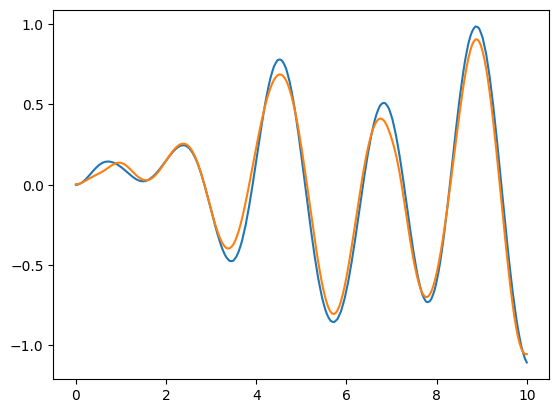

In [10]:
num = 2 #
x = x_test[num,:,:][None,:,:].cuda()
c = cx_test[num,:,:][None,:,:].cuda()
y = y_test[num,:,:][None,:,:].cpu()
# x = torch.ones(1,n,1).cuda() + 10
out = model(x,c).squeeze().cpu()
print(out.size())

plt.figure()
plt.plot(c.squeeze().cpu().detach().numpy(),y.squeeze().detach().numpy())
plt.plot(c.squeeze().cpu().detach().numpy(),out.detach().numpy())
plt.show()